In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py
import pqcd

from universality.gaussianprocess.utils import integrate_phi
from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre,
    nsat
    )

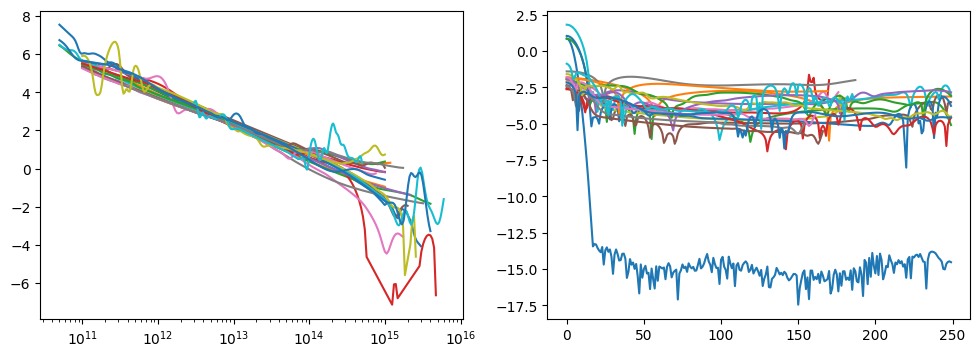

In [14]:
hdf5_paths = {
    'had': ['bsk', 'bsr', 'dd', 'eng', 'gm', 'kde', 'mpa', 'nl', 'r', 'sk', 'sly', 'tm'],
    'hyp': ['bsr', 'dd', 'gm', 'h', 'nl', 'tm'],
    'qrk': ['alf', 'ddq', 'hqc']
}

fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].set_xscale('log')

min_cov = 10

for variety in ['had', 'hyp', 'qrk']:

    for label in hdf5_paths[variety]:

        if variety == 'had':
            file_path = f'../make-agnostic-processes/{variety}agn/{label}/gpr_gpr_{variety}ronic-{label}.hdf5'
        elif variety == 'hyp':
            file_path = f'../make-agnostic-processes/{variety}agn/{label}/gpr_gpr_{variety}eronic-{label}.hdf5'
        elif variety == 'qrk':
            file_path = f'../make-agnostic-processes/{variety}agn/{label}/gpr_gpr_quark-{label}.hdf5'
        
        with h5py.File(file_path, 'r') as f:
            cov = np.array(f['0']['cov'])
            mean = np.array(f['0']['mean'])

        log_pressure = np.array([entry[0] for entry in mean])
        phi = np.array([entry[1] for entry in mean])

        axs[0].plot(np.exp(log_pressure), phi)
        axs[1].plot(np.log10(abs(cov[:,0])))

        if cov[0,0] < min_cov:
            min_cov_variety = variety
            min_cov_label = label
            min_cov = cov[0,0]

In [8]:
min_cov_variety, min_cov_label, min_cov

('had', 'eng', 0.002362851813474719)

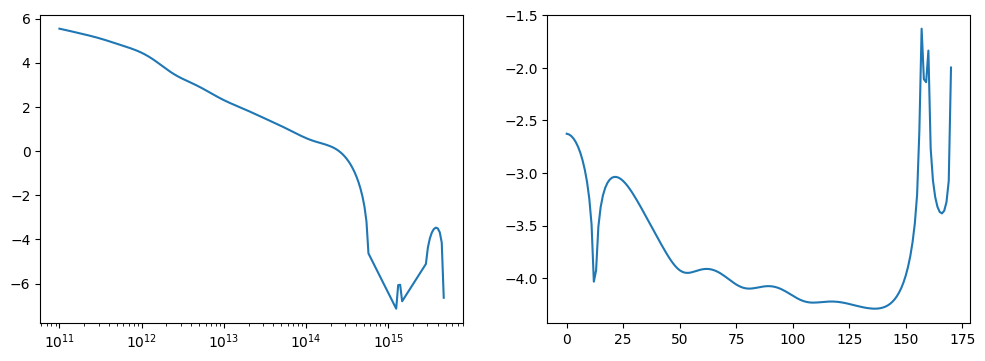

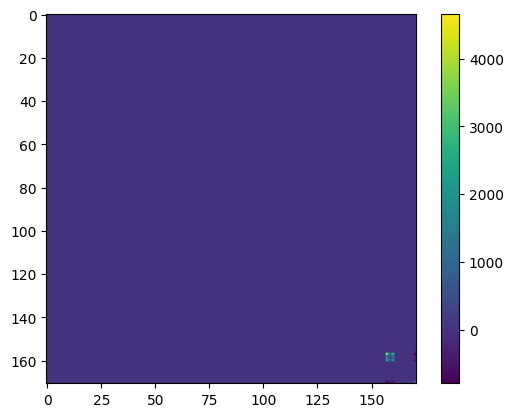

In [15]:
file_path = '../make-agnostic-processes/hadagn/eng/gpr_gpr_hadronic-eng.hdf5'

with h5py.File(file_path, 'r') as f:
    cov = np.array(f['0']['cov'])
    mean = np.array(f['0']['mean'])

log_pressure = np.array([entry[0] for entry in mean])
phi = np.array([entry[1] for entry in mean])

fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].set_xscale('log')

axs[0].plot(np.exp(log_pressure), phi)
axs[1].plot(np.log10(abs(cov[:,0])))

fig, ax = plt.subplots()

ax.imshow(cov, cmap='viridis')
fig.colorbar(ax.imshow(cov, cmap='viridis'));

Lets try modify an existing tabulated EOS...

In [32]:
# Load the mean we want to use as the new tabulated EOS. This could be from a 
# previous GP draw, or a random walk?

set = 6

gp_mean_dict = {}

for variety in ['had', 'hyp', 'qrk']:

    hdf5_path = f'../data/eos-draws-modified/{set:02}/{variety}agn/gpr_gpr_{variety}agn.hdf5'

    gp_mean_dict[variety] = {}

    with h5py.File(hdf5_path, 'r') as f:
        for key in f.keys():

            cov = np.array(f[key]['cov'])
            mean = np.array(f[key]['mean'])

            log_pressure = np.array([entry[0] for entry in mean])
            phi = np.array([entry[1] for entry in mean])

            gp_mean_dict[variety][key] = (log_pressure, phi)

consistent_phi_arrays = []
consistent_logp_arrays = []

N_samp = 2000

pqcd_region_dict = pqcd.get_pqcd_region()

for variety in ['had', 'hyp', 'qrk']:
    for n in range(N_samp):

        eos = pd.read_csv(
            f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv'
            )
        
        if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
            consistent=True
        
        else:
            consistent=False

        gp = pd.read_csv(
            f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/draw-gpr_{variety}agn-{n:06}.csv', comment='#'
            )
        
        if consistent:
            consistent_phi_arrays.append(gp['phi'].values)
            consistent_logp_arrays.append(gp['log(pressurec2)'].values)

In [43]:
# The log(p) arrays are all the same
new_logp = consistent_logp_arrays[0]

# Select our new mean
phi_array = np.array(consistent_phi_arrays)
new_mean_phi = phi_array[0]

In [44]:
len(new_logp), len(new_mean_phi)

(500, 500)

In [45]:
# We'll need a new covariance... use zeros?
new_cov_numpy = np.zeros((len(new_logp), len(new_logp)))

In [49]:
# The exisiting hdf5 we're going to try modify...
hdf5_path = '../make-agnostic-processes/hadagn/bsk/gpr_gpr_hadronic-bsk.hdf5'

with h5py.File(hdf5_path, 'r') as f:
    
    for key in f.keys():

        print(key)

        print(list(f[key].keys()))
        print(list(f[key].attrs))

        # Each tabulated EOS has some hyperparameters, but its not totally
        # clear to me how these are used (only weight is used in gpr-gpr from
        # what I can see)
        print(f[key].attrs['length_scale'])

        print()

        print(type(f[key]['mean']))
        print(f[key]['mean'])

        mean = np.array(f[key]['mean'])
        cov = np.array(f[key]['cov'])

        log_pressure_default = np.array([entry[0] for entry in mean])
        phi_default = np.array([entry[1] for entry in mean])


0
['cov', 'mean']
['flabel', 'length_scale', 'model_multiplier', 'poly_degree', 'sigma', 'sigma_obs', 'weight', 'xlabel']
0.09210541343

<class 'h5py._hl.dataset.Dataset'>
<HDF5 dataset "mean": shape (250,), type "|V16">


In [47]:
len(log_pressure_default), len(phi_default)

(250, 250)

In [48]:
mean

array([(24.63528884,  7.54411178), (24.67947398,  7.47105471),
       (24.72365912,  7.39875897), (24.76784426,  7.32721788),
       (24.8120294 ,  7.25642459), (24.85621454,  7.18637002),
       (24.90039968,  7.11702457), (24.94458482,  7.04821445),
       (24.98876996,  6.97900874), (25.0329551 ,  6.9056055 ),
       (25.07714024,  6.81688157), (25.12132538,  6.69160968),
       (25.16551052,  6.51084412), (25.20969566,  6.29204035),
       (25.2538808 ,  6.10665476), (25.29806594,  6.02452157),
       (25.34225108,  6.03162344), (25.38643622,  6.05090331),
       (25.43062136,  6.04214024), (25.4748065 ,  6.02272342),
       (25.51899164,  6.01389011), (25.56317678,  6.01976421),
       (25.60736192,  6.03234325), (25.65154706,  6.03810597),
       (25.6957322 ,  6.03016677), (25.73991734,  6.00846464),
       (25.78410248,  5.97618903), (25.82828762,  5.9384724 ),
       (25.87247276,  5.89662137), (25.9166579 ,  5.84790482),
       (25.96084304,  5.78966058), (26.00502818,  5.723

In [56]:
cov

array([[ 7.30167655e+00,  6.50802885e+00,  4.60818713e+00, ...,
        -3.11003393e-15, -3.40416739e-15, -2.97028027e-15],
       [ 6.50802885e+00,  7.30167655e+00,  6.50802885e+00, ...,
         2.04689069e-15,  2.59233756e-15,  2.92335549e-15],
       [ 4.60818713e+00,  6.50802885e+00,  7.30167655e+00, ...,
        -3.07371316e-15, -1.69713105e-14, -8.58243598e-15],
       ...,
       [-3.10829921e-15,  2.04666708e-15, -3.07371316e-15, ...,
         7.30130788e+00,  6.50791960e+00,  4.60816264e+00],
       [-3.40438423e-15,  2.59147020e-15, -1.69710937e-14, ...,
         6.50791960e+00,  7.30163093e+00,  6.50801644e+00],
       [-2.96854555e-15,  2.92335549e-15, -8.58156862e-15, ...,
         4.60816264e+00,  6.50801644e+00,  7.30167291e+00]])

In [51]:
new_mean = np.empty(len(new_logp), dtype=[('log(pressurec2)', 'float'), ('phi', 'float')])
new_mean['log(pressurec2)'][:] = new_logp
new_mean['phi'][:] = new_mean_phi

In [57]:
new_mean

array([(23.02585093,  6.71261871), (23.05353732,  6.63546778),
       (23.08122372,  6.56069595), (23.10891011,  6.49205944),
       (23.13659651,  6.4330449 ), (23.1642829 ,  6.38658219),
       (23.19196929,  6.3549672 ), (23.21965569,  6.33986149),
       (23.24734208,  6.34204763), (23.27502848,  6.36153178),
       (23.30271487,  6.39746111), (23.33040126,  6.44819013),
       (23.35808766,  6.5114153 ), (23.38577405,  6.58412652),
       (23.41346044,  6.66298185), (23.44114684,  6.74427632),
       (23.46883323,  6.82426656), (23.49651963,  6.8992592 ),
       (23.52420602,  6.96583506), (23.55189241,  7.02106797),
       (23.57957881,  7.06246422), (23.6072652 ,  7.08835507),
       (23.6349516 ,  7.09770041), (23.66263799,  7.09025017),
       (23.69032438,  7.06643298), (23.71801078,  7.02745664),
       (23.74569717,  6.97499513), (23.77338357,  6.91126126),
       (23.80106996,  6.83877779), (23.82875635,  6.76026505),
       (23.85644275,  6.67846452), (23.88412914,  6.596

In [58]:
hdf5_path_copy = 'gpr_gpr_custom-a.hdf5'

with h5py.File(hdf5_path, 'r') as f_src:
    with h5py.File(hdf5_path_copy, 'w') as f_dest:

        # Copy all the groups and datasets
        f_src.copy('0', f_dest)

        # Delete the original dataset
        del f_dest['0']['mean']
        del f_dest['0']['cov']

        # Create a new dataset
        f_dest['0'].create_dataset('mean', data=new_mean)
        f_dest['0'].create_dataset('cov', data=new_cov_numpy)

In [59]:
# Check that the copy worked

with h5py.File(hdf5_path_copy, 'r') as f:
        
        for key in f.keys():
    
            # There is only one key
            print(key)
    
            print()
    
            print(list(f[key].keys()))
            print(list(f[key].attrs))
    
            print()
    
            print(type(f[key]['mean']))
            print(f[key]['mean'])
    
            mean = np.array(f[key]['mean'])
    
            log_pressure_edit = np.array([entry[0] for entry in mean])
            phi_edit = np.array([entry[1] for entry in mean])

0

['cov', 'mean']
['flabel', 'length_scale', 'model_multiplier', 'poly_degree', 'sigma', 'sigma_obs', 'weight', 'xlabel']

<class 'h5py._hl.dataset.Dataset'>
<HDF5 dataset "mean": shape (500,), type "|V16">
